### Necessary Imports

In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import random
import numpy as np

parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)
from data import get_dataloader, dataloader_sampler, visualize_spectrogram

plt.style.use("default")

Loading the data and visualizing samples

In [2]:
speech_dir = os.path.abspath("../data/speech_files")
speech_files = glob.glob(os.path.join(speech_dir, "*.wav"))
train_dataloader, val_dataloader = get_dataloader(speech_dir)

In [3]:
dataloader_sampler(train_dataloader)

Sample 1 - Data shape: torch.Size([16, 1, 128, 256]), Target shape: torch.Size([16, 1, 128, 256])
Sample 2 - Data shape: torch.Size([16, 1, 128, 256]), Target shape: torch.Size([16, 1, 128, 256])
Sample 3 - Data shape: torch.Size([16, 1, 128, 256]), Target shape: torch.Size([16, 1, 128, 256])
Sample 4 - Data shape: torch.Size([16, 1, 128, 256]), Target shape: torch.Size([16, 1, 128, 256])


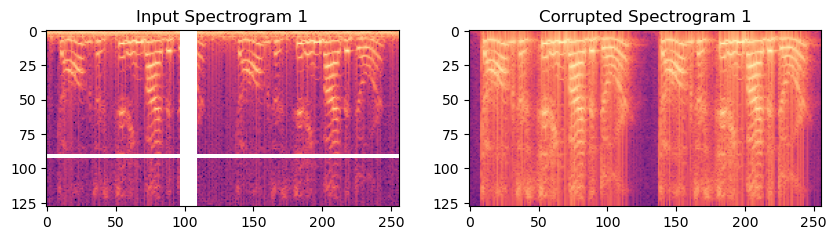

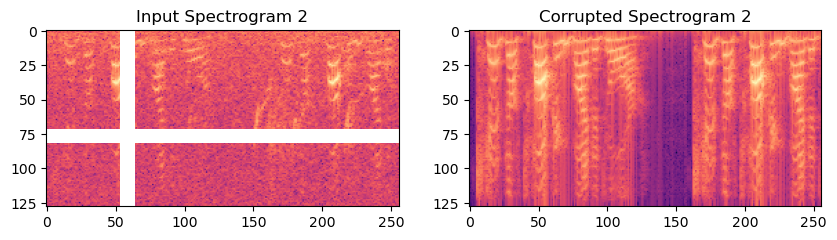

In [4]:
visualize_spectrogram(train_dataloader, num_samples=2)

### Initialize the model

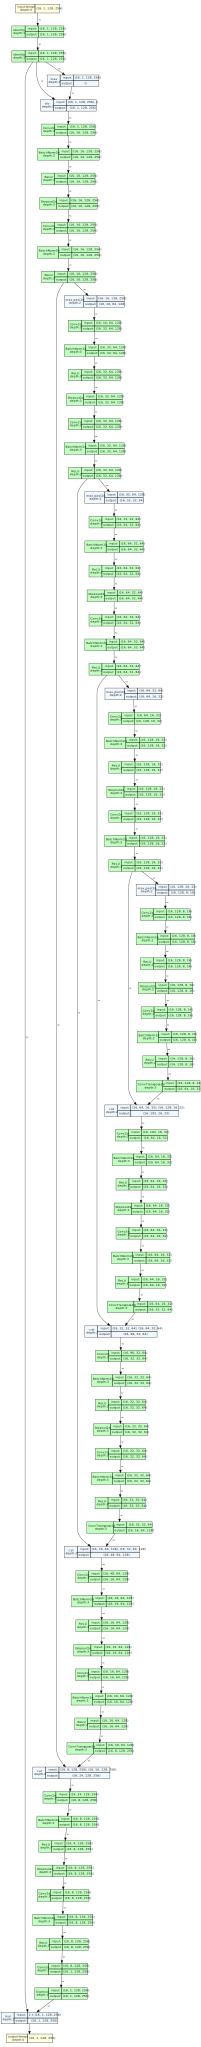

In [12]:
import torch
from src import CustomUNet
import graphviz
from torchview import draw_graph

graphviz.set_jupyter_format("svg")

# Initialize the model
model = CustomUNet(input_shape=(1, 128, 256), num_classes=1)
model.to(torch.device("cuda"))

batch_size = 16
model_graph = draw_graph(model, input_size=(batch_size, 1, 128, 256), device="meta")
model_graph.fill_visual_graph()
model_graph.visual_graph

In [6]:
# Set the random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

### Training and validation

### Evaluation